# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Modeling](#Modeling)
    - [Model Data](#Model-Data)
    - [K Nearest Neighbors](#K-Nearest-Neighbors)
    - [Cross Val Score](#Cross-Val-Score)
    - [Confusion Matrix](#Confusion-Matrix)
    - [Model Evaluation](#Model-Evaluation)

# Imports

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                            plot_confusion_matrix, silhouette_score, silhouette_samples)
from sklearn import metrics

# Data

In [2]:
data = pd.read_csv('./data/mlb-pitches.csv')
data.drop(columns = ['Unnamed: 0'], inplace = True) 

pd.set_option('max_columns', None)
print(data.shape)
data.head(3)

(708653, 76)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,post_away_score,post_home_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bauer_units,is_strike,pitch_count,swing_miss,plate_-x,pfx_-x
0,FF,2021-10-03,92.3,1.40,6.80,"Smith, Will",596019,519293,out,hit_into_play,1.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,X,5.0,ground_ball,1,2,2021,8.28,16.56,-0.69,2.83,NaN,NaN,NaN,2,9,Top,77.54,155.31,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,3.32,1.51,13.0,95.2,-13.0,92.8,2330.0,6.5,632254,54.03,0.174,0.158,0.0,1.0,0.0,0.0,2.0,61,4,4-Seam Fastball,5,0,0,5,Infield shift,Strategic,148.0,0.0,-0.073,25.243770,1,1-2,0,0.69,-8.28
1,SL,2021-10-03,80.6,1.60,6.64,"Smith, Will",596019,519293,NaN,foul,4.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,S,NaN,NaN,1,1,2021,-9.24,5.76,-0.71,2.62,NaN,NaN,NaN,2,9,Top,NaN,NaN,-3.700232,-117.430885,-3.266842,-6.531123,19.793390,-27.369114,3.32,1.51,108.0,75.3,75.0,81.2,2254.0,6.4,632254,54.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,Slider,5,0,0,5,Infield shift,Strategic,315.0,0.0,-0.027,27.965261,1,1-1,0,0.71,9.24
2,CU,2021-10-03,75.5,1.46,6.88,"Smith, Will",596019,519293,NaN,foul,5.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,S,NaN,NaN,1,0,2021,-7.80,-6.12,-0.04,2.46,NaN,NaN,NaN,2,9,Top,NaN,NaN,-1.977183,-109.901781,-1.155694,-4.872924,20.602334,-36.262184,3.32,1.51,157.0,83.5,65.0,75.2,1940.0,6.2,632254,54.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,2,Curveball,5,0,0,5,Infield shift,Standard,328.0,0.0,-0.020,25.695364,1,1-0,0,0.04,7.80


# Modeling

### Model Data

In [3]:
pitch = data[['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_-x', 'pfx_z',
              'release_extension', 'release_pos_x', 'release_pos_z', 'plate_x', 'plate_z', 'type']].copy()
pitch.dropna(inplace = True)
pitch['type'].replace(['X'], 'S', inplace = True)
# Strike 1 Ball 0
pitch['type'] = pitch['type'].map({'S': 1, 'B': 0})
print(pitch.shape)
pitch.head()

(705445, 11)


,release_speed,release_spin_rate,spin_axis,pfx_-x,pfx_z,release_extension,release_pos_x,release_pos_z,plate_x,plate_z,type
0,92.3,2330.0,148.0,-8.28,16.56,6.5,1.40,6.80,-0.69,2.83,1
1,80.6,2254.0,315.0,9.24,5.76,6.4,1.60,6.64,-0.71,2.62,1
2,75.5,1940.0,328.0,7.80,-6.12,6.2,1.46,6.88,-0.04,2.46,1
3,75.0,2017.0,330.0,8.28,-8.28,5.9,1.53,6.83,2.10,3.89,0
4,91.2,2281.0,143.0,-7.56,15.36,6.3,1.49,6.66,-0.31,2.80,1


### K Nearest Neighbors

In [4]:
X = pitch.drop(columns = ['type'])
y = pitch['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2, random_state = 1)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.fit_transform(X_test)

knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train_sc, y_train)

print('Train: {}'.format(knn.score(X_train_sc, y_train)))
print('Test: {}'.format(knn.score(X_test_sc, y_test)))

Train: 0.8897982833530609
Test: 0.8355080835500995


### Cross Val Score

In [5]:
scores = cross_val_score(knn, 
                         X_train_sc, y_train,
                         cv = 5)
print('Accuracy: {:.2f} ± {:.2f}'.format(scores.mean(), 
                                 2 * scores.std()))

Accuracy: 0.84 ± 0.00


### Confusion Matrix

Confusion matrix:
[[36859 14144]
 [ 9064 81022]]


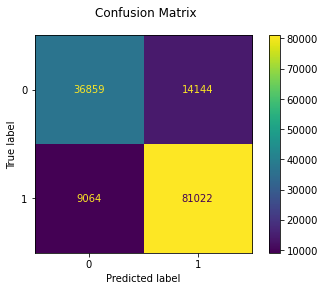

In [6]:
predictions = knn.predict(X_test_sc)

disp = plot_confusion_matrix(knn, X_test_sc, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)
plt.show();

### Model Evaluation

In [7]:
print("Classification report for classifier %s:\n%s\n"
      % (knn, classification_report(y_test, predictions)))

Classification report for classifier KNeighborsClassifier(n_jobs=-1):
              precision    recall  f1-score   support

           0       0.80      0.72      0.76     51003
           1       0.85      0.90      0.87     90086

    accuracy                           0.84    141089
   macro avg       0.83      0.81      0.82    141089
weighted avg       0.83      0.84      0.83    141089


